## RSA Excluding Site KKI

## Imports

In [181]:
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import time
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
from sklearn.decomposition import PCA
from make_models import get_MRI_CVAE_3D
from tqdm import tqdm
import tensorflow as tf
from rsa_funcs import fit_rsa,make_RDM,get_triu

In [182]:
pwd

'/mmfs1/data/bergerar/BC-MRI-ADHD/Code'

## Load and Sort Data

In [183]:
stuff = np.load('../Assets/brain_array-440.npz')
print(list(stuff.keys()))

data = stuff['data']
control = stuff['controls']
patients = stuff['patients']
n = data.shape[0]
#print(data.shape)
#data[patients,:,:,:].shape
#data[patients].shape

data_patients = data[patients,:,:,:]
data_controls = data[control,:,:,:]

print(data_patients.shape)
print(data_controls.shape)

['data', 'controls', 'patients']
(179, 64, 64, 64)
(261, 64, 64, 64)


## CVAE

In [184]:
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CVAE_3D(input_shape=(64,64,64,1),
                    latent_dim=2,
                    beta=1,
                    disentangle=False,
                    gamma=1,
                    bias=True,
                    batch_size = 64,
                    kernel_size = 3,
                    filters = 32,
                    intermediate_dim = 128,
                    opt=None)

## Load Weights

In [185]:
cvae.load_weights('../Assets/tf_weights_10000_AB/tf_weightsAB')

In [186]:
data_patients.shape

(179, 64, 64, 64)

## Read DF

In [195]:
df = pd.read_csv('../Data/df_440_normed.csv')

In [217]:
df

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  Subject  \
0             0            26              26                26       26   
1             1            27              27                27       27   
2             2            28              28                28       28   
3             3            29              29                29       29   
4             4            30              30                30       30   
..          ...           ...             ...               ...      ...   
435         435           707             707               707      707   
436         436           709             709               709      709   
437         437           711             711               711      711   
438         438           714             714               714      714   
439         439           715             715               715      715   

     ScanDir ID  Site  Gender    Age  Handedness  ...  QC_Rest_3 QC_Rest_4  \
0     2371032.0     3     0.0  10.73         1.0  ...        NaN       NaN   
1     2026113.0     3     0.0  12.99         1.0  ...        NaN       NaN   
2     3434578.0     3     0.0   8.12         1.0  ...        NaN       NaN   
3     8628223.0     3     0.0  10.81         1.0  ...        NaN       NaN   
4     1623716.0     3     0.0  12.65         1.0  ...        NaN       NaN   
..          ...   ...     ...    ...         ...  ...        ...       ...   
435     16081.0     7     1.0  18.81         1.0  ...        NaN       NaN   
436     16003.0     7     1.0  10.46         1.0  ...        NaN       NaN   
437     16057.0     7     0.0  16.74         1.0  ...        NaN       NaN   
438     16023.0     7     0.0  12.51         0.0  ...        NaN       NaN   
439     16054.0     7     1.0  16.05         1.0  ...        NaN       NaN   

     QC_Anatomical_1  QC_Anatomical_2  ID        subID  has_brain  \
0                1.0              NaN NaN  sub-2371032       True   
1                1.0              NaN NaN  sub-2026113       True   
2                1.0              NaN NaN  sub-3434578       True   
3                1.0              NaN NaN  sub-8628223       True   
4                1.0              NaN NaN  sub-1623716       True   
..               ...              ...  ..          ...        ...   
435              1.0              NaN NaN  sub-0016081       True   
436              0.0              NaN NaN  sub-0016003       True   
437              1.0              NaN NaN  sub-0016057       True   
438              1.0              NaN NaN  sub-0016023       True   
439              1.0              NaN NaN  sub-0016054       True   

     ADHD Index Normed  Inattentive Normed  Hyper/Impulsive Normed  
0             0.118644                0.30                0.040816  
1             0.847458                0.98                0.755102  
2             0.033898                0.04                0.040816  
3             0.033898                0.18                0.163265  
4             0.796610                1.00                1.000000  
..                 ...                 ...                     ...  
435                NaN                 NaN                     NaN  
436                NaN                 NaN                     NaN  
437                NaN                 NaN                     NaN  
438                NaN                 NaN                     NaN  
439                NaN                 NaN                     NaN  

[440 rows x 34 columns]

## Replace Site 3 Data with Nan

In [222]:
lst = [1,4,7,8,9,17,22,26,27,30,45,46,54,62,66,67,68,69,70,74,77,81]
for i in lst:
    df.loc[df['Unnamed: 0'].eq(i), ['Site', 'Gender', 'Age', 'Handedness', 'ADHD Index Normed', 'Hyper/Impulsive Normed', 'Inattentive Normed', 'Full4 IQ', 'Performance IQ', 'Verbal IQ', ]] = float('nan')

In [223]:
df

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  Subject  \
0             0            26              26                26       26   
1             1            27              27                27       27   
2             2            28              28                28       28   
3             3            29              29                29       29   
4             4            30              30                30       30   
..          ...           ...             ...               ...      ...   
435         435           707             707               707      707   
436         436           709             709               709      709   
437         437           711             711               711      711   
438         438           714             714               714      714   
439         439           715             715               715      715   

     ScanDir ID  Site  Gender    Age  Handedness  ...  QC_Rest_3 QC_Rest_4  \
0     2371032.0   3.0     0.0  10.73         1.0  ...        NaN       NaN   
1     2026113.0   NaN     NaN    NaN         NaN  ...        NaN       NaN   
2     3434578.0   3.0     0.0   8.12         1.0  ...        NaN       NaN   
3     8628223.0   3.0     0.0  10.81         1.0  ...        NaN       NaN   
4     1623716.0   NaN     NaN    NaN         NaN  ...        NaN       NaN   
..          ...   ...     ...    ...         ...  ...        ...       ...   
435     16081.0   7.0     1.0  18.81         1.0  ...        NaN       NaN   
436     16003.0   7.0     1.0  10.46         1.0  ...        NaN       NaN   
437     16057.0   7.0     0.0  16.74         1.0  ...        NaN       NaN   
438     16023.0   7.0     0.0  12.51         0.0  ...        NaN       NaN   
439     16054.0   7.0     1.0  16.05         1.0  ...        NaN       NaN   

     QC_Anatomical_1  QC_Anatomical_2  ID        subID  has_brain  \
0                1.0              NaN NaN  sub-2371032       True   
1                1.0              NaN NaN  sub-2026113       True   
2                1.0              NaN NaN  sub-3434578       True   
3                1.0              NaN NaN  sub-8628223       True   
4                1.0              NaN NaN  sub-1623716       True   
..               ...              ...  ..          ...        ...   
435              1.0              NaN NaN  sub-0016081       True   
436              0.0              NaN NaN  sub-0016003       True   
437              1.0              NaN NaN  sub-0016057       True   
438              1.0              NaN NaN  sub-0016023       True   
439              1.0              NaN NaN  sub-0016054       True   

     ADHD Index Normed  Inattentive Normed  Hyper/Impulsive Normed  
0             0.118644                0.30                0.040816  
1                  NaN                 NaN                     NaN  
2             0.033898                0.04                0.040816  
3             0.033898                0.18                0.163265  
4                  NaN                 NaN                     NaN  
..                 ...                 ...                     ...  
435                NaN                 NaN                     NaN  
436                NaN                 NaN                     NaN  
437                NaN                 NaN                     NaN  
438                NaN                 NaN                     NaN  
439                NaN                 NaN                     NaN  

[440 rows x 34 columns]

## Make ADHD Dataframe

In [224]:
ADHDdf = df[df['DX'] != 0]

In [225]:
# ADHDdf.to_csv('../Data/ADHDdf_179.csv')

In [226]:
ADHDdf

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  Subject  \
1             1            27              27                27       27   
4             4            30              30                30       30   
7             7            33              33                33       33   
8             8            34              34                34       34   
9             9            35              35                35       35   
..          ...           ...             ...               ...      ...   
381         381           572             572               572      572   
383         383           577             577               577      577   
386         386           581             581               581      581   
393         393           602             602               602      602   
394         394           609             609               609      609   

     ScanDir ID  Site  Gender    Age  Handedness  ...  QC_Rest_3 QC_Rest_4  \
1     2026113.0   NaN     NaN    NaN         NaN  ...        NaN       NaN   
4     1623716.0   NaN     NaN    NaN         NaN  ...        NaN       NaN   
7     3154996.0   NaN     NaN    NaN         NaN  ...        NaN       NaN   
8     3160561.0   NaN     NaN    NaN         NaN  ...        NaN       NaN   
9     4275075.0   NaN     NaN    NaN         NaN  ...        NaN       NaN   
..          ...   ...     ...    ...         ...  ...        ...       ...   
381   2367157.0   1.0     1.0  12.08         1.0  ...        NaN       NaN   
383   2697768.0   1.0     0.0  12.58         1.0  ...        NaN       NaN   
386   2897046.0   1.0     0.0   9.17         1.0  ...        NaN       NaN   
393   3976121.0   1.0     1.0  11.00         1.0  ...        NaN       NaN   
394   4334113.0   1.0     1.0  14.58         1.0  ...        NaN       NaN   

     QC_Anatomical_1  QC_Anatomical_2  ID        subID  has_brain  \
1                1.0              NaN NaN  sub-2026113       True   
4                1.0              NaN NaN  sub-1623716       True   
7                1.0              NaN NaN  sub-3154996       True   
8                1.0              NaN NaN  sub-3160561       True   
9                1.0              NaN NaN  sub-4275075       True   
..               ...              ...  ..          ...        ...   
381           -999.0              NaN NaN  sub-2367157       True   
383              1.0              NaN NaN  sub-2697768       True   
386              1.0              NaN NaN  sub-2897046       True   
393              1.0              NaN NaN  sub-3976121       True   
394           -999.0              NaN NaN  sub-4334113       True   

     ADHD Index Normed  Inattentive Normed  Hyper/Impulsive Normed  
1                  NaN                 NaN                     NaN  
4                  NaN                 NaN                     NaN  
7                  NaN                 NaN                     NaN  
8                  NaN                 NaN                     NaN  
9                  NaN                 NaN                     NaN  
..                 ...                 ...                     ...  
381           1.000000                1.00                1.000000  
383           0.520833                0.68                0.375000  
386                NaN                 NaN                     NaN  
393           0.500000                0.60                0.416667  
394           0.625000                0.64                0.625000  

[179 rows x 34 columns]

## Notes on booleans

In [227]:
np.array(True) + np.array(False)
np.array(False) + np.array(False)
np.array(True) * np.array(False)
np.array(False) * np.array(False)
# for booleans + means or , * means and

False

In [228]:
~np.array(True)

False

## RDMS: ADHD Index

In [229]:
symptom_vector = ADHDdf['ADHD Index Normed'].values
symptom_vector

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.33898305, 0.62711864, 0.77966102,
       0.40677966, 0.37288136, 0.40677966, 0.38983051, 0.62711864,
       0.52542373, 0.61016949, 0.74576271, 0.33898305, 0.49152542,
       0.57627119, 0.25423729, 0.38983051, 0.59322034, 0.54237288,
       0.27118644, 0.62711864, 0.42372881, 0.71186441, 0.59322034,
       0.49152542, 0.61016949, 0.72881356, 0.55932203, 0.52542373,
       0.30508475, 0.84745763, 0.54237288, 0.66101695, 0.44067797,
       0.59322034, 0.40677966, 0.38983051, 0.77966102, 0.57627119,
       0.71186441, 0.57627119, 0.38983051, 0.55932203, 0.42372881,
       0.33898305, 0.54237288, 0.61016949, 0.37288136, 0.84745763,
       0.47457627, 0.74576271, 0.45762712, 0.61016949, 0.61016

In [230]:
is_999 = symptom_vector==-999

In [231]:
is_nan = np.isnan(symptom_vector)

In [232]:
is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [233]:
is_not_nan = ~is_nan
is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [234]:
is_not_999 = ~is_999
is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [235]:
good_subjects = is_not_999 * is_not_nan
good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [236]:
symptom_good_patients = symptom_vector[good_subjects]

In [237]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
symptom = np.array(symptom_good_patients)

In [238]:
z_good_patients = z_patients[good_subjects,:]

In [239]:
s_good_patients = s_patients[good_subjects,:]

In [240]:
s_patients_rdm = make_RDM(s_good_patients)
z_patients_rdm = make_RDM(z_good_patients)
symptom_rdm = make_RDM(symptom_good_patients)

In [241]:
symptom_rdm.shape

(125, 125)

In [242]:
z_patients_rdm.shape

(125, 125)

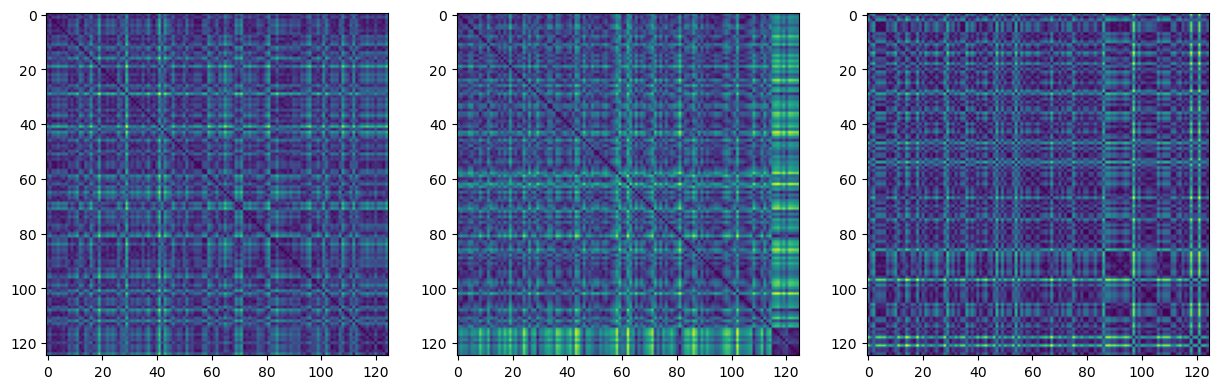

In [243]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.subplot(1,3,3)
plt.imshow(symptom_rdm)
plt.show()

## RSA: ADHD Index

In [244]:
s_symptom_rsa = fit_rsa(s_patients_rdm, symptom_rdm)
s_symptom_rsa

-0.04861533766473035

In [245]:
z_symptom_rsa = fit_rsa(z_patients_rdm, symptom_rdm)
z_symptom_rsa

0.03046505668591127

## RDMS: Inattentive Index

In [246]:
inattentive_vector = ADHDdf['Inattentive Normed'].values
inattentive_vector

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,  0.32,  0.82,  0.84,  0.24,  0.52,
        0.58,  0.46,  0.72,  0.68,  0.74,  0.8 ,  0.42,  0.48,  0.56,
        0.22,  0.42,  0.68,  0.62,  0.44,  0.8 ,  0.48,  0.8 ,  0.6 ,
        0.66,  0.76,  1.  ,  0.66,  0.72,  0.5 ,  1.  ,  0.64,  0.86,
        0.8 ,  0.56,  0.5 ,  0.42,  0.88,  0.8 ,  0.78,  0.66,  0.42,
        0.56,  0.72,  0.48,  0.4 ,  0.66,  0.3 ,  1.  ,  0.48,  0.88,
        0.54,  0.58,  0.72,  0.48,  1.  ,  0.38,  0.54,  0.68,  0.72,
        0.66,  0.54,  0.7 ,  0.74,  0.78,  0.54,  0.38,   nan,  0.58,
        0.34,   nan,  0.82,  0.78,  0.56,  0.78,  0.64,  0.82,  0.78,
        0.22,  0.52,  0.76,  0.66,  0.64,  0.66,  0.58,  0.66,  0.82,
        0.58,  0.5 ,  1.  ,  0.48,  0.36,  0.36,  0.38,  0.52,  0.32,
        0.46,  0.32,  0.42,  0.66,  0.74,  0.64,  0.92,  0.58,  0.4 ,
        0.78,  0.68,

In [247]:
inattentive_is_999 = inattentive_vector==-999

In [248]:
inattentive_is_nan = np.isnan(inattentive_vector)

In [249]:
inattentive_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [250]:
inattentive_is_not_nan = ~inattentive_is_nan
inattentive_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [251]:
inattentive_is_not_999 = ~inattentive_is_999
inattentive_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [252]:
inattentive_good_subjects = inattentive_is_not_999 * inattentive_is_not_nan
inattentive_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [253]:
inattentive_good_patients = inattentive_vector[inattentive_good_subjects]

In [254]:
z_good_patients_inattentive = z_patients[inattentive_good_subjects,:]
s_good_patients_inattentive = s_patients[inattentive_good_subjects,:]

In [255]:
s_patients_rdm_inattentive = make_RDM(s_good_patients_inattentive)
z_patients_rdm_inattentive = make_RDM(z_good_patients_inattentive)
inattentive_rdm = make_RDM(inattentive_good_patients)

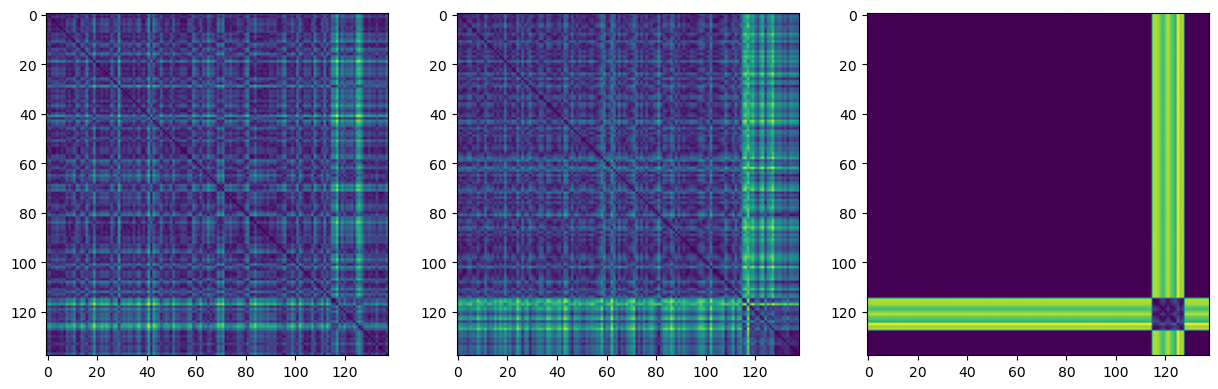

In [256]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_inattentive)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_inattentive)
plt.subplot(1,3,3)
plt.imshow(inattentive_rdm)
plt.show()

## RSA: Inattentive Index

In [257]:
s_inattentive_rsa = fit_rsa(s_patients_rdm_inattentive, inattentive_rdm)
s_inattentive_rsa

0.4188833129186429

In [258]:
z_inattentive_rsa = fit_rsa(z_patients_rdm_inattentive, inattentive_rdm)
z_inattentive_rsa

0.5999220215549899

## RDMS: Hyperactive/Impulsive Index

In [259]:
HI_vector = ADHDdf['Hyper/Impulsive Normed'].values
HI_vector

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 1.42857143e-01, 7.95918367e-01,
       8.97959184e-01, 5.91836735e-01, 4.08163265e-02, 4.89795918e-01,
       2.24489796e-01, 9.38775510e-01, 4.28571429e-01, 5.51020408e-01,
       5.30612245e-01, 5.10204082e-01, 4.89795918e-01, 8.36734694e-01,
       4.48979592e-01, 3.67346939e-01, 6.32653061e-01, 7.75510204e-01,
       2.24489796e-01, 5.91836735e-01, 5.51020408e-01, 7.75510204e-01,
       5.10204082e-01, 6.73469388e-01, 6.32653061e-01, 4.89795918e-01,
       3.46938776e-01, 1.83673469e-01, 3.06122449e-01, 7.95918367e-01,
       6.32653061e-01, 7.14285714e-01, 5.71428571e-01, 4.48979592e-01,
      

In [260]:
HI_is_999 = HI_vector==-999

In [261]:
HI_is_nan = np.isnan(HI_vector)

In [262]:
HI_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [263]:
HI_is_not_nan = ~HI_is_nan
HI_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [264]:
HI_is_not_999 = ~HI_is_999
HI_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [265]:
HI_good_subjects = HI_is_not_999 * HI_is_not_nan
HI_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [266]:
HI_good_patients = HI_vector[HI_good_subjects]

In [267]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
HI = np.array(HI_good_patients)

In [268]:
z_good_patients_HI = z_patients[HI_good_subjects,:]

In [269]:
s_good_patients_HI = s_patients[HI_good_subjects,:]

In [270]:
s_patients_rdm_HI = make_RDM(s_good_patients_HI)
z_patients_rdm_HI = make_RDM(z_good_patients_HI)
HI_rdm = make_RDM(HI_good_patients)

In [271]:
s_patients_rdm_HI.shape

(138, 138)

In [272]:
z_patients_rdm_HI.shape

(138, 138)

In [273]:
HI_rdm.shape

(138, 138)

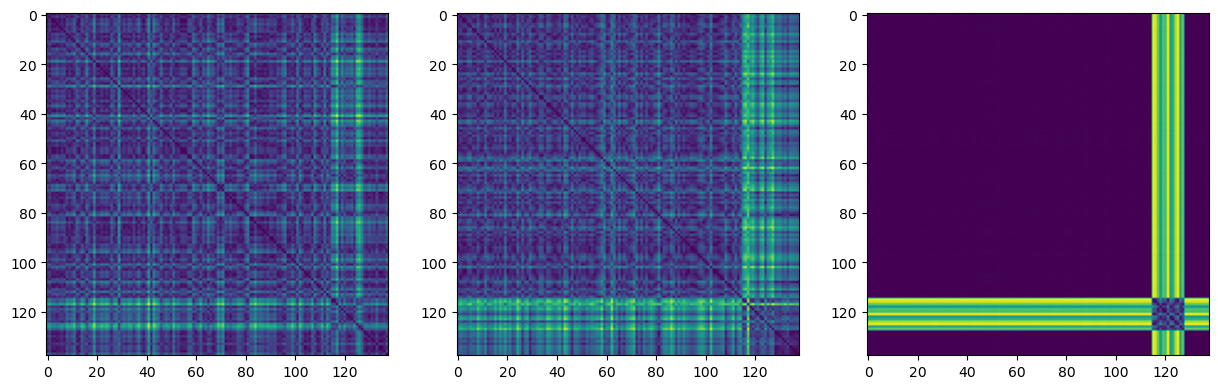

In [274]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_HI)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_HI)
plt.subplot(1,3,3)
plt.imshow(HI_rdm)
plt.show()

## RSA: Hyperactive/Impulsive Index

In [275]:
s_HI_rsa = fit_rsa(s_patients_rdm_HI, HI_rdm)
s_HI_rsa

0.39931380051217263

In [276]:
z_HI_rsa = fit_rsa(z_patients_rdm_HI, HI_rdm)
z_HI_rsa

0.5607707685705569

## RDMS: Age

In [306]:
age_vector = ADHDdf['Age'].values
age_vector

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,  8.29,  8.78,  8.04, 12.79,  9.57,
        8.61, 13.32,  8.56, 10.12, 10.06, 10.26, 11.18,  7.55,  7.26,
       13.56,  8.11, 10.41,  9.17, 12.07, 11.06, 11.53, 11.61, 13.49,
       10.78,  8.53,  8.38, 10.69,  9.17, 11.28, 12.28, 12.62,  8.49,
        8.61, 10.21, 10.36,  9.26,  7.86,  8.05,  9.24,  7.49,  9.38,
       11.97, 11.8 ,  9.32, 10.81,  9.23, 13.28, 10.16,  7.24, 11.33,
        9.92, 10.7 , 10.92,  9.98, 11.17, 11.92, 12.41, 11.54,  8.37,
       12.12,  9.42, 12.41, 11.1 ,  8.95, 10.9 , 10.65,  9.81, 17.43,
       15.4 , 15.63, 14.95,  8.75, 12.72, 11.41, 16.14, 15.9 ,  7.77,
       16.08, 17.37, 14.81,  8.19, 16.32,  8.93, 14.39, 14.94, 14.2 ,
       17.15, 13.24,  9.16, 15.32, 11.21, 11.82, 16.77, 13.33, 11.73,
        8.06, 11.09,  9.59, 15.81, 11.37, 15.83, 17.61,  8.75, 13.09,
       12.38,  7.35,

In [307]:
age_is_nan = np.isnan(age_vector)
age_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [309]:
age_is_not_nan = ~age_is_nan
age_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [310]:
age_good_patients = age_vector[age_is_not_nan]

In [311]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
age = np.array(age_good_patients)

In [312]:
z_good_patients_age = z_patients[age_is_not_nan,:]

In [313]:
s_good_patients_age = s_patients[age_is_not_nan,:]

In [314]:
s_patients_rdm_age = make_RDM(s_good_patients_age)
z_patients_rdm_age = make_RDM(z_good_patients_age)
age_rdm = make_RDM(age)

In [315]:
s_patients.shape

(179, 2)

In [316]:
z_patients.shape

(179, 2)

In [317]:
age_vector.shape

(179,)

In [318]:
s_patients_rdm_age.shape

(157, 157)

In [319]:
z_patients_rdm_age.shape

(157, 157)

In [320]:
age_rdm.shape

(157, 157)

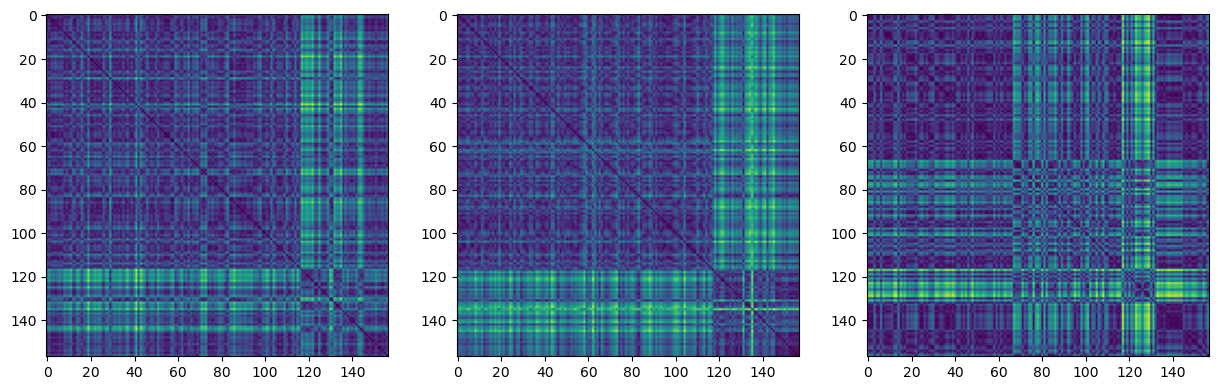

In [321]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_age)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_age)
plt.subplot(1,3,3)
plt.imshow(age_rdm)
plt.show()

## RSA: Age

In [322]:
s_age_rsa = fit_rsa(s_patients_rdm_age, age_rdm)
s_age_rsa

0.09739039017978178

In [323]:
z_age_rsa = fit_rsa(z_patients_rdm_age, age_rdm)
z_age_rsa

-0.014882791497080152

## RDMS: Gender

In [324]:
gender_vector = ADHDdf['Gender'].values
gender_vector

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  0.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.])

In [325]:
gender_is_999 = gender_vector==-999

In [326]:
gender_is_nan = np.isnan(gender_vector)

In [327]:
gender_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [328]:
gender_is_not_nan = ~gender_is_nan
gender_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [329]:
gender_is_not_999 = ~gender_is_999
gender_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [330]:
gender_good_subjects = gender_is_not_999 * gender_is_not_nan
gender_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [331]:
gender_good_patients = gender_vector[gender_good_subjects]

In [332]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]

In [333]:
z_good_patients_gender = z_patients[gender_good_subjects,:]

In [334]:
s_good_patients_gender = s_patients[gender_good_subjects,:]

In [335]:
s_patients_rdm_gender = make_RDM(s_good_patients_gender)
z_patients_rdm_gender = make_RDM(z_good_patients_gender)
gender_rdm = make_RDM(gender_good_patients,data_scale='ordinal')

In [336]:
s_patients_rdm_gender.shape

(156, 156)

In [337]:
z_patients_rdm_gender.shape

(156, 156)

In [338]:
gender_rdm.shape

(156, 156)

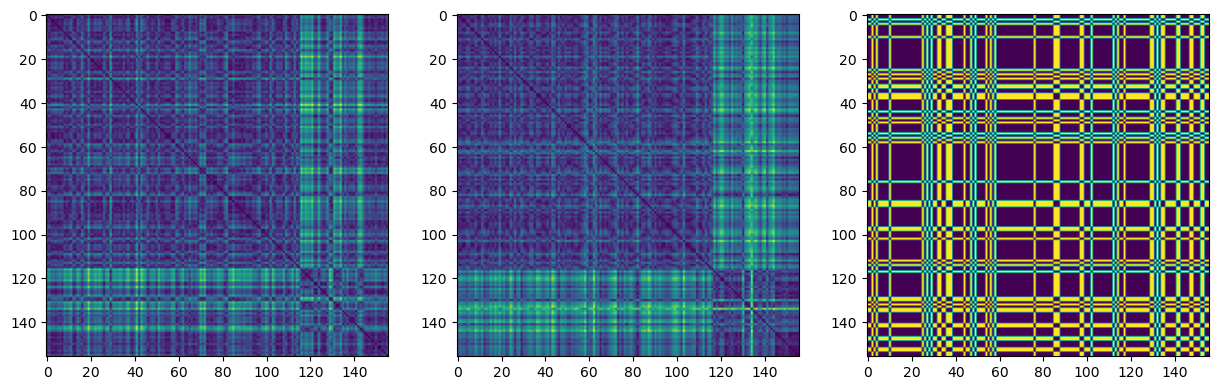

In [339]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_gender)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_gender)
plt.subplot(1,3,3)
plt.imshow(gender_rdm)
plt.show()

## RSA: Gender

In [340]:
s_gender_rsa = fit_rsa(s_patients_rdm_gender, gender_rdm)
s_gender_rsa

0.006098792333671898

In [341]:
z_gender_rsa = fit_rsa(z_patients_rdm_gender, gender_rdm)
z_gender_rsa

0.05022968923959429

## RDMS: Handedness

In [342]:
handed_vector = ADHDdf['Handedness'].values
handed_vector

array([      nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,  5.70e-01, -9.99e+02,
        5.00e-01,  7.30e-01,  2.60e-01,  6.70e-01,  9.10e-01,  6.20e-01,
        8.30e-01,  4.70e-01,  6.50e-01,  5.20e-01,  2.90e-01,  1.30e-01,
        3.10e-01,  2.70e-01,  9.10e-01,  5.80e-01,  1.10e-01,  8.60e-01,
        9.10e-01,  6.00e-01,  1.00e+00,  1.00e+00,  8.20e-01,  6.40e-01,
        6.80e-01,  4.50e-01,  1.00e+00,  6.80e-01,  8.30e-01,  9.50e-01,
        4.40e-01,  2.00e-01,  8.20e-01,  1.00e+00,  8.20e-01,  1.00e+00,
        3.90e-01,  1.60e-01,  2.40e-01,  1.00e+00,  8.60e-01,  8.20e-01,
        4.60e-01,  7.70e-01,  8.20e-01,  1.60e-01,  5.80e-01,  6.90e-01,
        9.10e-01,  1.00e+00,  1.00e+00,  7.40e-01,  5.20e-01,  6.80e-01,
        4.20e-01,  5.70e-01,  7.90e-01,  2.20e-01, 

In [343]:
handed_is_999 = handed_vector==-999

In [344]:
handed_is_nan = np.isnan(handed_vector)

In [345]:
handed_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [346]:
handed_is_not_nan = ~handed_is_nan
handed_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [347]:
handed_is_not_999 = ~handed_is_999
handed_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [348]:
handed_good_subjects = handed_is_not_999 * handed_is_not_nan
handed_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [349]:
handed_good_patients = handed_vector[handed_good_subjects]

In [350]:
s_patients = s_encoder.predict(data_patients)[0]
z_patients = z_encoder.predict(data_patients)[0]
handed = np.array(handed_good_patients)

In [351]:
z_good_patients_handed = z_patients[handed_good_subjects,:]

In [352]:
s_good_patients_handed = s_patients[handed_good_subjects,:]

In [353]:
s_patients_rdm_handed = make_RDM(s_good_patients_handed)
z_patients_rdm_handed = make_RDM(z_good_patients_handed)
handed_rdm = make_RDM(handed_good_patients)

In [354]:
s_patients_rdm_handed.shape

(156, 156)

In [355]:
z_patients_rdm_handed.shape

(156, 156)

In [356]:
handed_rdm.shape

(156, 156)

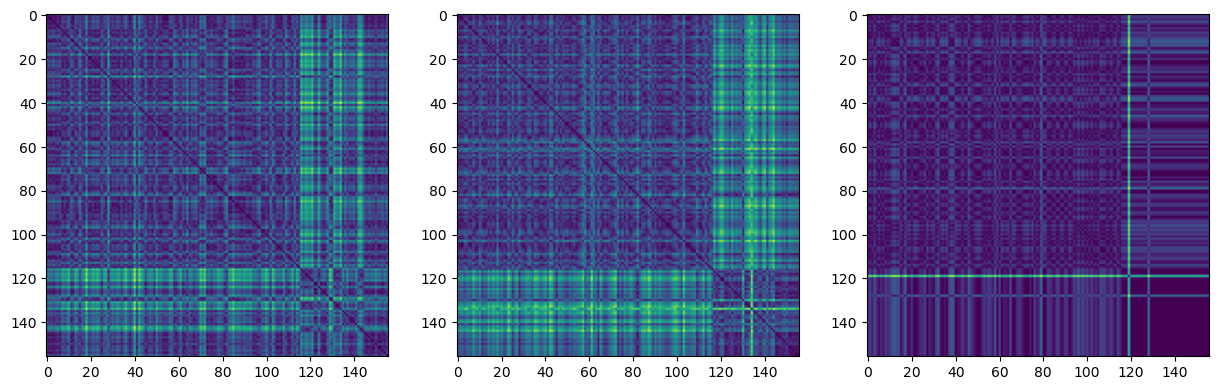

In [357]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_handed)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_handed)
plt.subplot(1,3,3)
plt.imshow(handed_rdm)
plt.show()

## RSA: Handedness

In [358]:
s_handedness_rsa = fit_rsa(s_patients_rdm_handed, handed_rdm)
s_handedness_rsa

0.08762730565595601

In [359]:
z_handedness_rsa = fit_rsa(z_patients_rdm_handed, handed_rdm)
z_handedness_rsa

0.10516885677321716

## RDMS: IQ

In [360]:
IQ_vector = ADHDdf['Full4 IQ'].values
IQ_vector

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,  123.,  129.,  116.,  129.,  118.,
        107.,   99.,  125.,  108.,  125.,  119.,  107.,  125.,  115.,
        131.,  102.,  109.,   95.,   98.,  105.,  111.,  116.,   84.,
        107.,  114.,  109.,  134.,  124.,   97.,  107.,  132.,   99.,
        117.,  100.,  102.,  128.,  128.,  107.,   88.,  103.,  106.,
        102.,   95.,   95.,  108.,  119.,  109.,  115.,   94.,  109.,
        101.,  134.,   95.,  132.,   99.,  108.,  100.,   94.,   95.,
        105.,   92.,  103.,   89.,  109.,   91.,  108.,  108.,  109.,
        107., -999.,  118.,   99.,  122.,  101.,  122.,  101.,   94.,
        115.,  102.,  120.,  121.,   94.,   83.,   81.,  113.,   92.,
        115.,   75.,  106.,   93.,  129.,   99.,  114.,   84.,  131.,
         88.,   73.,  106., -999.,   78.,  102.,   95.,   99.,  127.,
         94.,  106.,

In [361]:
IQ_is_999 = IQ_vector==-999
IQ_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [362]:
IQ_is_nan = np.isnan(IQ_vector)

In [363]:
IQ_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [364]:
IQ_is_not_nan = ~IQ_is_nan
IQ_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [365]:
IQ_is_not_999 = ~IQ_is_999
IQ_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [366]:
IQ_good_subjects = IQ_is_not_999 * IQ_is_not_nan
IQ_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [367]:
IQ_good_patients = IQ_vector[IQ_good_subjects]

In [368]:
s_patients_IQ = s_encoder.predict(data_patients)[0]
z_patients_IQ = z_encoder.predict(data_patients)[0]
IQ = np.array(IQ_good_patients)

In [369]:
z_good_patients_IQ = z_patients_IQ[IQ_good_subjects,:]

In [370]:
s_good_patients_IQ = s_patients_IQ[IQ_good_subjects,:]

In [371]:
s_patients_rdm_IQ = make_RDM(s_good_patients_IQ)
z_patients_rdm_IQ = make_RDM(z_good_patients_IQ)
IQ_rdm = make_RDM(IQ)

In [372]:
IQ_rdm.shape

(139, 139)

In [373]:
z_patients_rdm_IQ.shape

(139, 139)

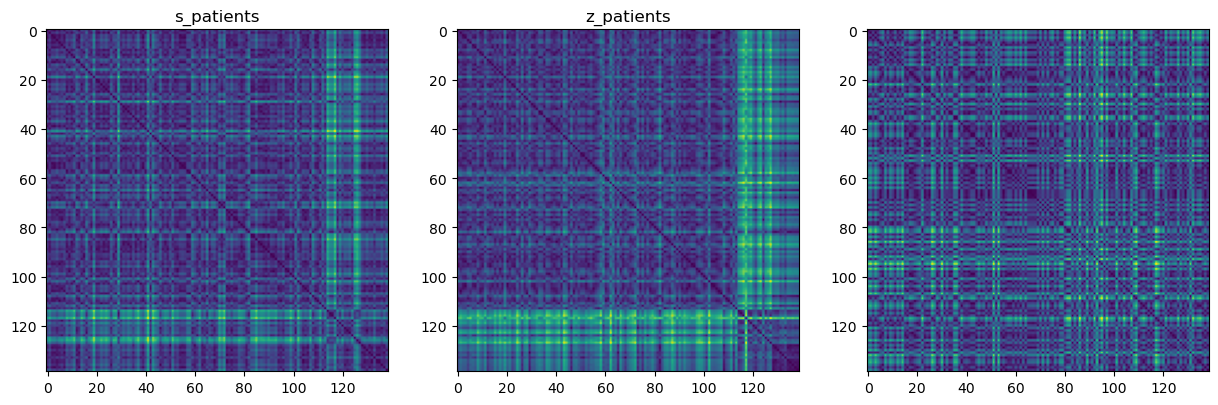

In [374]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_IQ)
plt.title('s_patients')
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_IQ)
plt.title('z_patients')
plt.subplot(1,3,3)
plt.imshow(IQ_rdm)
plt.show()

## RSA: IQ

In [375]:
s_iq_rsa = fit_rsa(s_patients_rdm_IQ, IQ_rdm)
s_iq_rsa

-0.021209129493897885

In [376]:
z_iq_rsa = fit_rsa(z_patients_rdm_IQ, IQ_rdm)
z_iq_rsa

-0.021562810728381926

## RDMS: Verbal IQ

In [377]:
verbal_vector = ADHDdf['Verbal IQ'].values
verbal_vector

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,  115.,  131.,  109.,  109.,  122.,
        106.,  106.,  126.,  110.,  125.,  108.,   96.,  115.,  120.,
        141.,  101.,  109.,   98.,  108.,  114.,  115.,  107.,   88.,
        106.,  118.,   98.,  123.,  116.,   99.,  108.,  137.,  109.,
        123.,  104.,  107.,  135.,  123.,   98.,   99.,  106.,  106.,
        114.,   85.,   99.,  122.,  118.,  105.,  117.,  101.,  101.,
         97.,  136.,   95.,  130.,  106.,   98.,  102.,   89.,  105.,
        108.,   99.,  100.,   91.,  109.,  100.,  100.,   98.,  119.,
        109., -999.,  120.,   93.,  109.,   99.,  132.,   95.,  101.,
        122.,  104.,  116.,  113.,   96.,   77.,   81.,  119.,  107.,
        116.,   65.,  102.,   98.,  119.,  106.,  115.,   89.,  132.,
         92.,   77.,  106., -999.,   82.,  109.,   82.,  109.,  126.,
         98.,  115.,

In [378]:
verbal_is_999 = verbal_vector==-999
verbal_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [379]:
verbal_is_nan = np.isnan(verbal_vector)
verbal_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [380]:
verbal_is_not_nan = ~verbal_is_nan
verbal_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [381]:
verbal_is_not_999 = ~verbal_is_999
verbal_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [382]:
verbal_good_subjects = verbal_is_not_999 * verbal_is_not_nan
verbal_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [383]:
verbal_good_patients = verbal_vector[verbal_good_subjects]

In [384]:
s_patients_verbal = s_encoder.predict(data_patients)[0]
z_patients_verbal = z_encoder.predict(data_patients)[0]
verbal = np.array(verbal_good_patients)

In [385]:
z_good_patients_verbal = z_patients_verbal[verbal_good_subjects,:]

In [386]:
s_good_patients_verbal = s_patients_verbal[verbal_good_subjects,:]

In [387]:
s_patients_rdm_verbal = make_RDM(s_good_patients_verbal)
z_patients_rdm_verbal = make_RDM(z_good_patients_verbal)
verbal_rdm = make_RDM(verbal)

In [388]:
verbal_rdm.shape

(125, 125)

In [389]:
z_patients_rdm_verbal.shape

(125, 125)

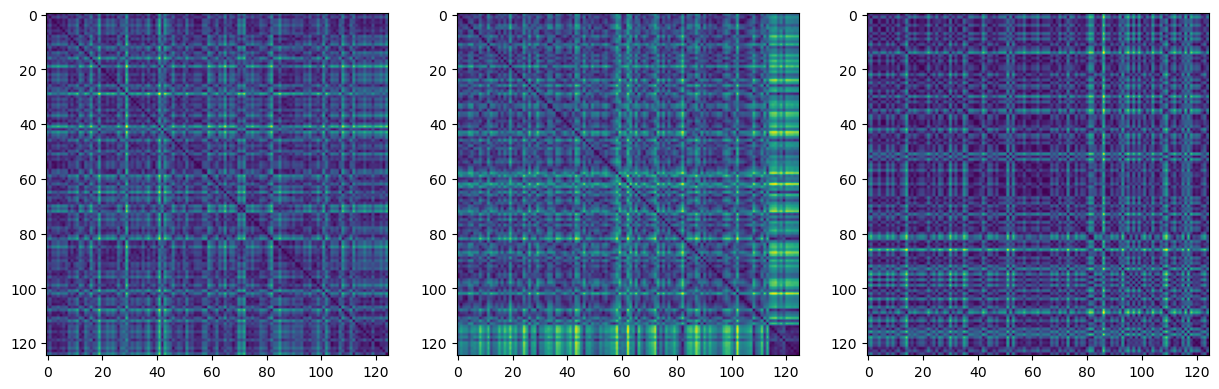

In [390]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_verbal)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_verbal)
plt.subplot(1,3,3)
plt.imshow(verbal_rdm)
plt.show()

## RSA: Verbal IQ

In [391]:
s_verbal_rsa = fit_rsa(s_patients_rdm_verbal, verbal_rdm)
s_verbal_rsa

-0.014148502598609503

In [392]:
z_verbal_rsa = fit_rsa(z_patients_rdm_verbal, verbal_rdm)
z_verbal_rsa

-0.003985178541174655

## RDMS: Performance IQ

In [393]:
performance_vector = ADHDdf['Performance IQ'].values
performance_vector

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,  125.,  121.,  120.,  134.,  109.,
        106.,   91.,  119.,  104.,  117.,  128.,  118.,  129.,  106.,
        114.,  103.,  106.,   93.,   88.,   94.,  104.,  123.,   82.,
        107.,  107.,  120.,  137.,  126.,   95.,  103.,  119.,   88.,
        107.,   97.,   97.,  116.,  126.,   94.,   82.,  100.,  104.,
         89.,  107.,   92.,   93.,  117.,  111.,  109.,   88.,  116.,
        106.,  124.,   96.,  127.,   91.,  118.,   97.,  100.,   86.,
        100.,   87.,  105.,   91.,  106.,   85.,  115.,  119.,   97.,
        102., -999.,  111.,  104.,  131.,  103.,  107.,  107.,   88.,
        105.,   99.,  119.,  125.,   93.,   93.,   84.,  104.,   79.,
        115.,   89.,  107.,   89.,  133.,   91.,  109.,   83.,  123.,
         88.,   72.,  104., -999.,   79.,   93.,  108.,   88.,  121.,
         90.,   96.,

In [394]:
performance_is_999 = performance_vector==-999
performance_is_999

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [395]:
performance_is_nan = np.isnan(performance_vector)
performance_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [396]:
performance_is_not_nan = ~performance_is_nan
performance_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [397]:
performance_is_not_999 = ~performance_is_999
performance_is_not_999

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [398]:
performance_good_subjects = performance_is_not_999 * performance_is_not_nan
performance_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,

In [399]:
performance_good_patients = performance_vector[performance_good_subjects]

In [400]:
s_patients_performance = s_encoder.predict(data_patients)[0]
z_patients_performance = z_encoder.predict(data_patients)[0]
performance = np.array(performance_good_patients)

In [401]:
z_good_patients_performance = z_patients_performance[performance_good_subjects,:]

In [402]:
s_good_patients_performance = s_patients_performance[performance_good_subjects,:]

In [403]:
s_patients_rdm_performance = make_RDM(s_good_patients_performance)
z_patients_rdm_performance = make_RDM(z_good_patients_performance)
performance_rdm = make_RDM(performance)

In [404]:
performance_rdm.shape

(125, 125)

In [405]:
z_patients_rdm_performance.shape

(125, 125)

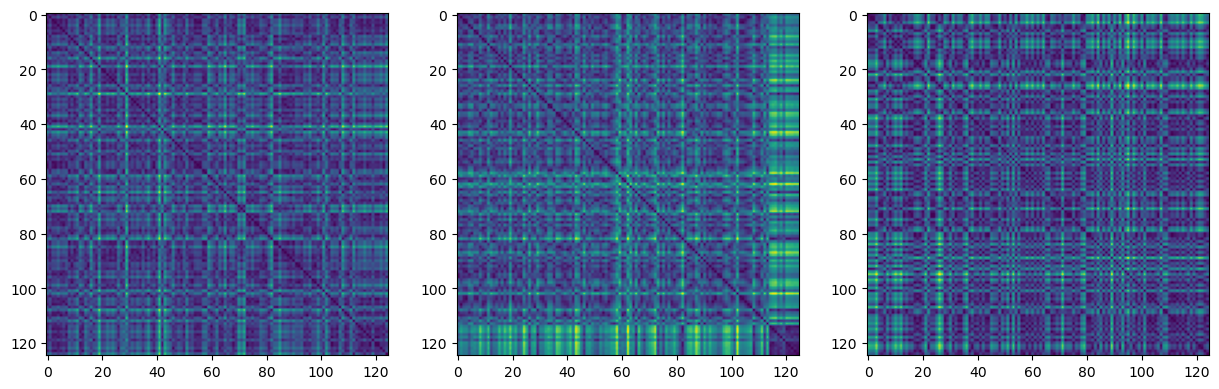

In [406]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm_performance)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm_performance)
plt.subplot(1,3,3)
plt.imshow(performance_rdm)
plt.show()

## RSA: Performance IQ

In [407]:
s_performance_rsa = fit_rsa(s_patients_rdm_performance, performance_rdm)
s_performance_rsa

-0.06239194522882691

In [408]:
z_performance_rsa = fit_rsa(z_patients_rdm_performance, performance_rdm)
z_performance_rsa

-0.03424217904449632

## RDMS: Site

In [409]:
site = ADHDdf['Site'].values
site

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [415]:
site_is_nan = np.isnan(site)
site_is_nan

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [416]:
site_is_not_nan = ~site_is_nan
site_is_not_nan

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [417]:
site_good_subjects = site_is_not_nan
site_good_subjects

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [421]:
site_good_patients = site[site_good_subjects]

In [425]:
s_patients_site = s_encoder.predict(data_patients)[0]
z_patients_site = z_encoder.predict(data_patients)[0]
site_array = np.array(site_good_patients)

In [426]:
z_good_patients_site = z_patients_site[site_good_subjects,:]

In [427]:
s_good_patients_site = s_patients_site[site_good_subjects,:]

In [434]:
s_patients_rdm = make_RDM(s_good_patients_site)
z_patients_rdm = make_RDM(z_good_patients_site)
site_rdm = make_RDM(site_array,data_scale='ordinal') # Ordinal data 

In [435]:
site_rdm.shape

(157, 157)

In [436]:
z_patients_rdm.shape

(157, 157)

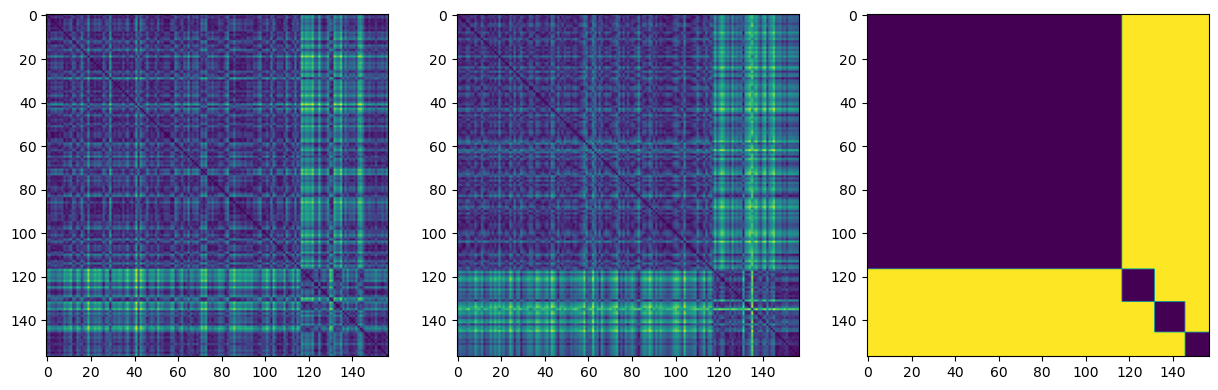

In [437]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(s_patients_rdm)
plt.subplot(1,3,2)
plt.imshow(z_patients_rdm)
plt.subplot(1,3,3)
plt.imshow(site_rdm)
plt.show()

## RSA: Site

In [438]:
s_site_rsa = fit_rsa(s_patients_rdm, site_rdm)
s_site_rsa

0.3610140585789109

In [439]:
z_site_rsa = fit_rsa(z_patients_rdm, site_rdm)
z_site_rsa

0.5484472523748464

## RSA Bar Plot

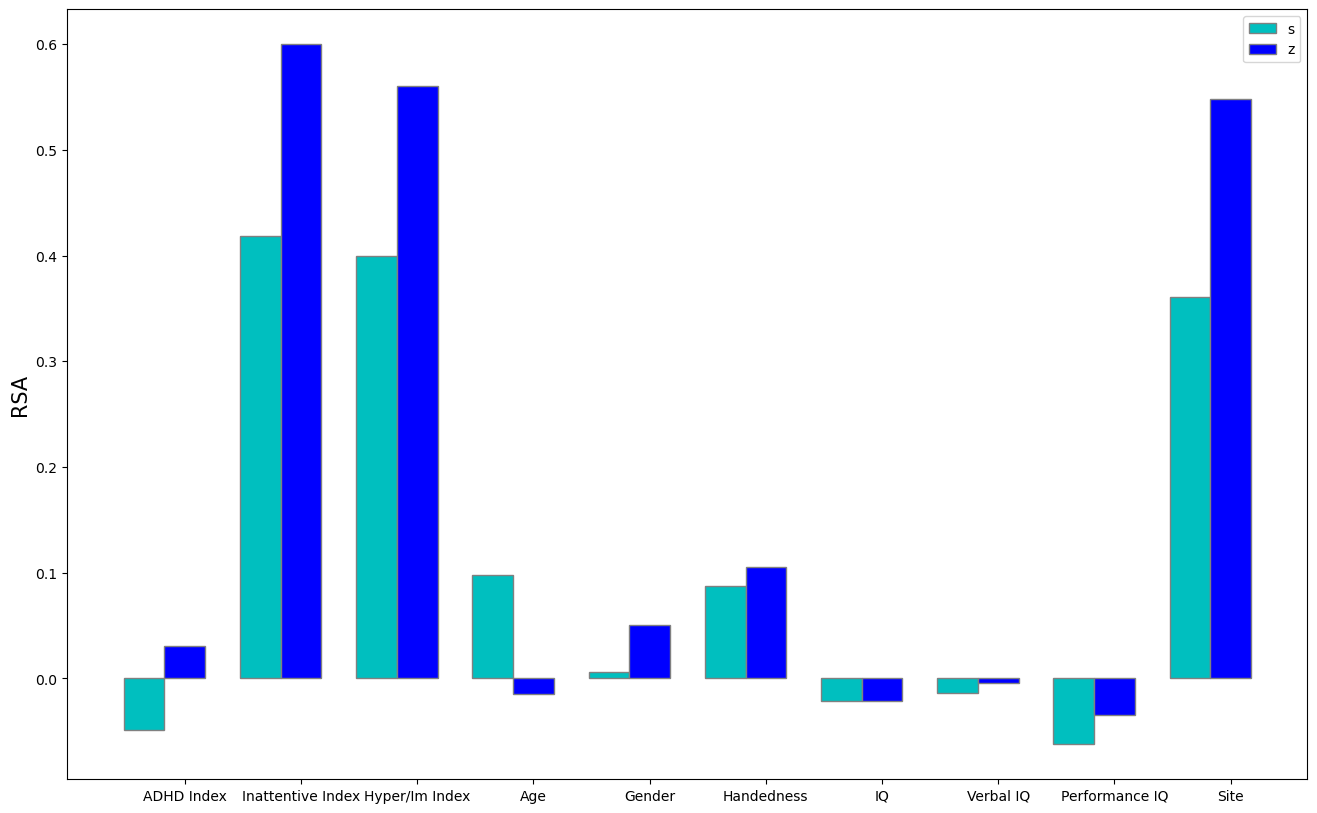

In [440]:
# set width of bar
barWidth = 0.35
fig = plt.subplots(figsize =(16, 10))

# set height of bar
s = [s_symptom_rsa, s_inattentive_rsa, s_HI_rsa, s_age_rsa, s_gender_rsa, s_handedness_rsa, s_iq_rsa, s_verbal_rsa, s_performance_rsa, s_site_rsa]
z = [z_symptom_rsa, z_inattentive_rsa, z_HI_rsa, z_age_rsa, z_gender_rsa, z_handedness_rsa, z_iq_rsa, z_verbal_rsa, z_performance_rsa, z_site_rsa]
 
# set position of bar on x axis
br1 = np.arange(len(s))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# make plot
plt.bar(br1, s, color ='c', width = barWidth,
        edgecolor ='grey', label ='s')
plt.bar(br2, z, color ='b', width = barWidth,
        edgecolor ='grey', label ='z')
 
# add xticks
# fontweight ='bold'
# plt.xlabel('Measure', fontsize = 15)
# title?
plt.ylabel('RSA', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(s))],
        ['ADHD Index', 'Inattentive Index', 'Hyper/Im Index', 'Age', 'Gender', 'Handedness', 'IQ', 'Verbal IQ', 'Performance IQ', 'Site'])
 
plt.legend()
plt.show()